In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import statsmodels.api as sm
import pandas.tseries
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import itertools
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_csv('zillow_data.csv')

In [2]:
#importing data on US 10 year treasury rates i.e. risk free rate
rfr = pd.read_csv('DGS10.csv')
rfr.DATE = pd.to_datetime(rfr.DATE,infer_datetime_format=True)
rfr = rfr.set_index('DATE')

#cleaing this for string issues and converting to float, also resampling from daily to monthly ts
#and trimming to fit our dataset
rfr = rfr[rfr.DGS10 != '.']
rfr.DGS10 = rfr.DGS10.apply(lambda x: np.float(x))
rfr = rfr.resample('MS',).mean()
rfr = rfr[3:-1]
rfr.DGS10 = rfr.DGS10/100

In [ ]:
westminster = df.loc[df['City']=='Westminster'].drop(columns=['RegionID','City', 'CountyName', 'Metro', 'State','SizeRank'],
                                           axis=1).groupby('RegionName').mean()

In [4]:
west = df.loc[df['City']=='Westminster'].drop(columns=['RegionID','City', 'CountyName', 'Metro', 'State','SizeRank'],
                                           axis=1).groupby('RegionName').mean()
west = pd.DataFrame(west.reset_index())
west_columns = list(west.T.iloc[0])
west = west.T
west.columns = west_columns
west = west[1:]
west = west.set_index(pd.to_datetime(west.index))
west = west.applymap(lambda x: round(np.float(x),2))

In [5]:
west_list = list(west.columns)
len(west_list)

10

In [6]:
west_dfs = []
for x in west_list:
    x = pd.DataFrame(data = west[x])
    west_dfs.append(x)

In [7]:
for y in west_dfs:
    y['ROI_MoM'] = np.zeros((265))
    y['ROI_YoY'] = np.zeros((265))
    for x in range(0,265):    
        if x + 1 <265:
            y.iloc[x+1,1] = round((y.iloc[x+1,0] - y.iloc[x,0])/y.iloc[x,0],4)
        else: break
    for x in range(0,265):    
        if x + 12 <265:
            y.iloc[x+12,2] = round((y.iloc[x+12,0] - y.iloc[x,0])/y.iloc[x,0],4)
        else: break
    y['EMA_6MO_roi_mo'] = y.ROI_MoM.ewm(span=6,adjust=False).mean()
    y['EMA_6MO_std_mo'] = y.ROI_MoM.ewm(span=6,adjust=False).std()
    y['EMA_6MO_roi_y'] = y.ROI_YoY.ewm(span=6,adjust=False).mean()
    y['EMA_6MO_std_y'] = y.ROI_YoY.ewm(span=6,adjust=False).std()
    y['rfr'] = rfr.DGS10
    y['sharpe_ratio_monthly'] = (y['EMA_6MO_roi_mo'] - (y.rfr/12))/y['EMA_6MO_std_mo']
    y['sharpe_ratio_annual'] = (y['EMA_6MO_roi_y'] - (y.rfr))/y['EMA_6MO_std_y']

In [8]:
westy = list(west.columns)
avg_5_mo = []
avg_5_y = []
avg_10_mo = []
avg_10_y= []
avg_1_mo =[]
avg_1_y=[]
avg_3_mo = []
avg_3_y = []
for w in west_dfs:
    avg_1_mo.append(w['2017-04-01':].sharpe_ratio_monthly.mean())
    avg_1_y.append(w['2017-04-01':].sharpe_ratio_annual.mean())
    avg_5_mo.append(w['2013':'2018'].sharpe_ratio_monthly.mean())
    avg_5_y.append(w['2013':'2018'].sharpe_ratio_annual.mean())
    avg_10_mo.append(w['2008':'2018'].sharpe_ratio_monthly.mean())
    avg_10_y.append(w['2008':'2018'].sharpe_ratio_annual.mean())
    avg_3_mo.append(w['2015-04-01':].sharpe_ratio_monthly.mean())
    avg_3_y.append(w['2015-04-01':].sharpe_ratio_annual.mean())
west_averages = pd.concat([pd.DataFrame(westy,dtype='str'),pd.DataFrame(avg_1_mo,dtype=float),pd.DataFrame(avg_1_y,dtype=float),
                            pd.DataFrame(avg_3_mo,dtype=float),pd.DataFrame(avg_3_y,dtype=float),
                            pd.DataFrame(avg_5_mo,dtype=float),pd.DataFrame(avg_5_y,dtype=float),
                                pd.DataFrame(avg_10_mo,dtype=float),pd.DataFrame(avg_10_y,dtype=float)],axis=1)
west_averages.columns = ['Westminster Zipcodes','1yr_average_mo','1yr_average_y',
                          '3yr_average_mo','3yr_average_y',
                          '5yr_average_mo','5yr_average_y',
                          '10yr_average_mo','10yr_average_y']

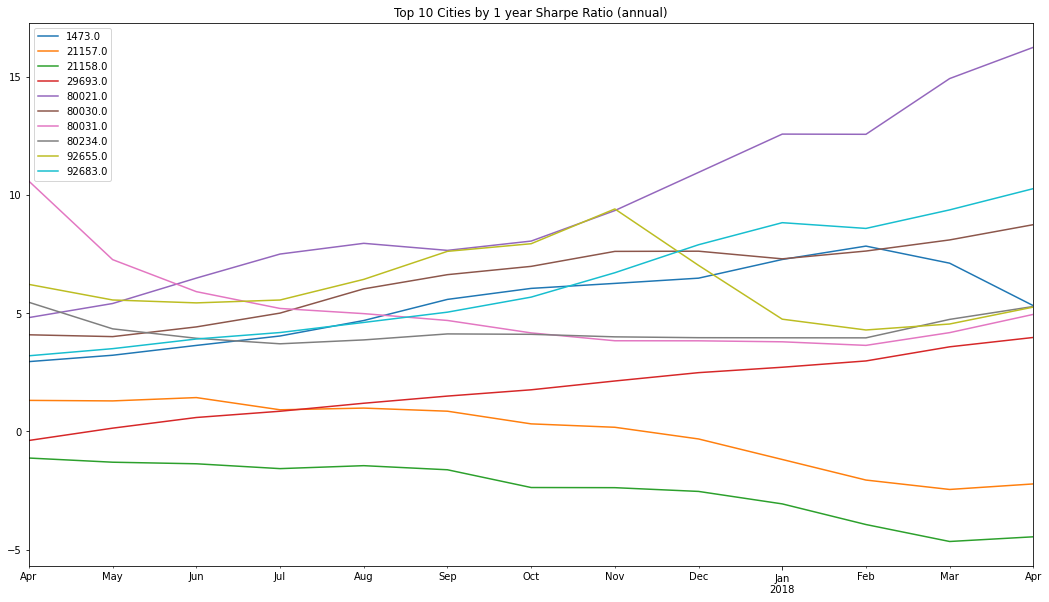

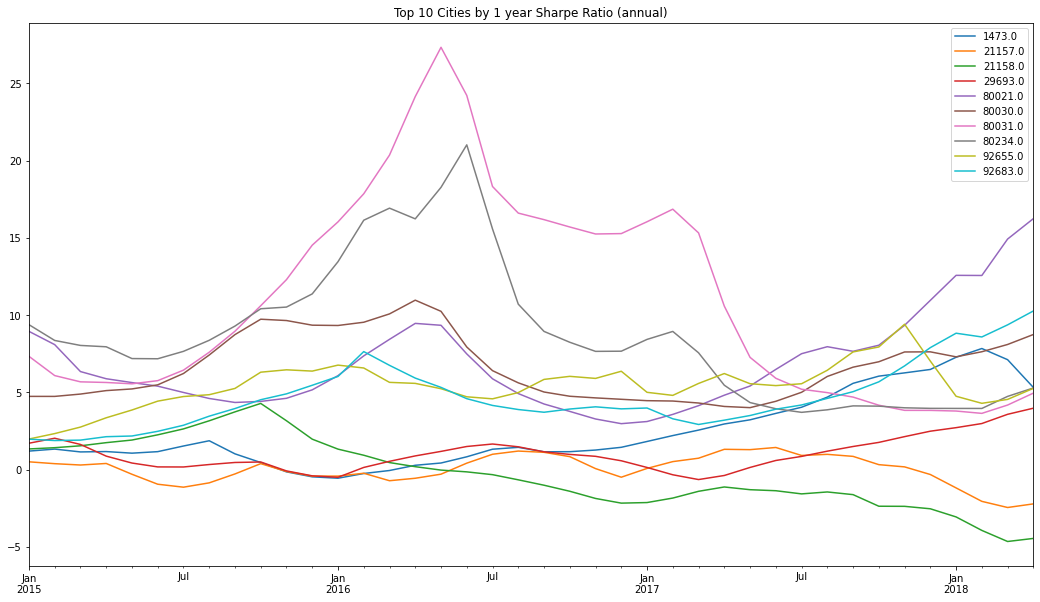

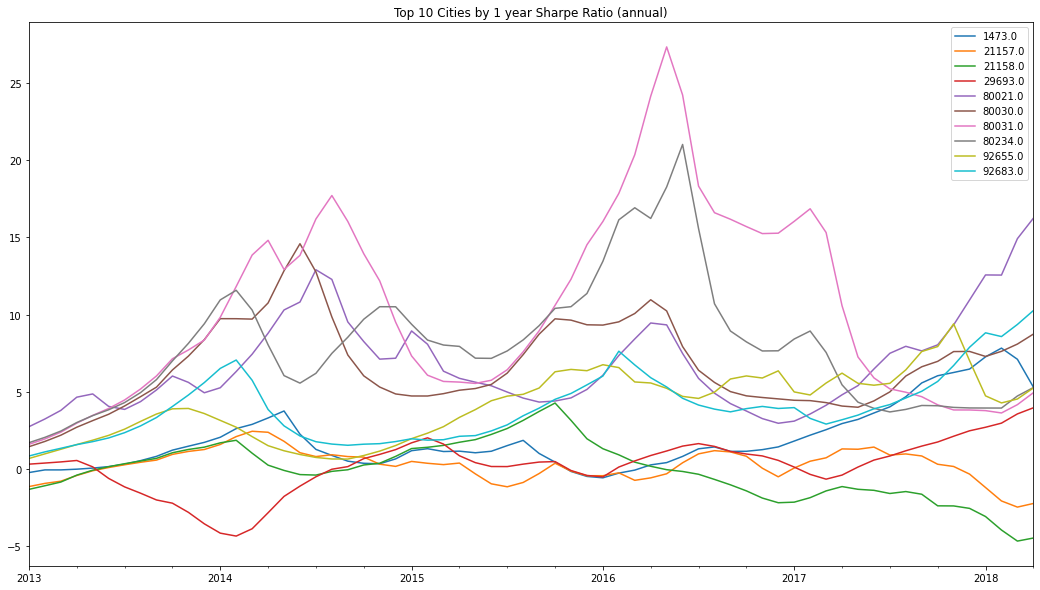

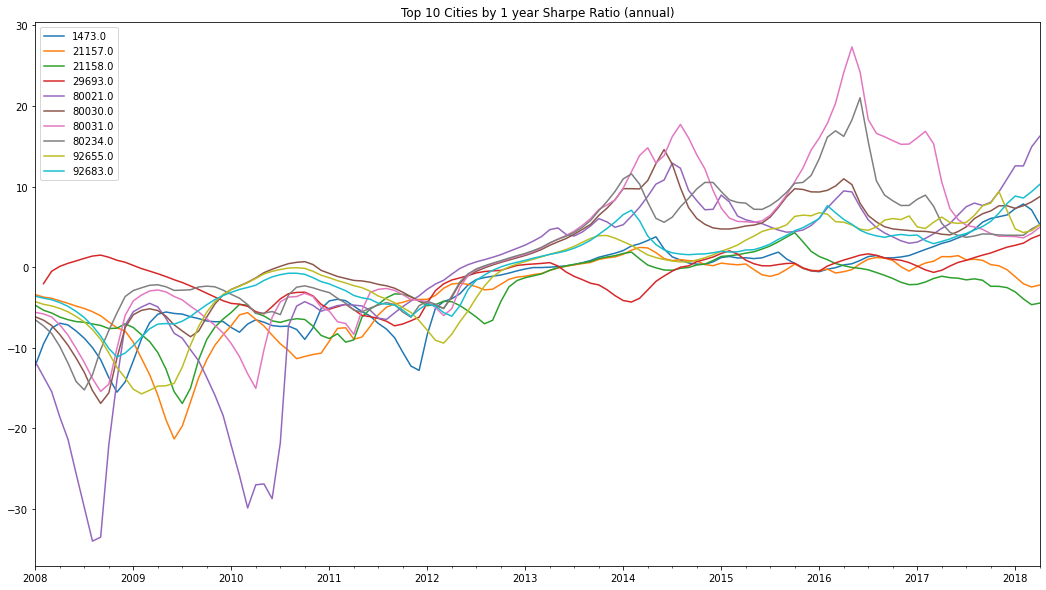

In [16]:
fig1, ax1 = plt.subplots(figsize=(18,10))
for zipcode in west_dfs:
    zipcode['2017-04-01':'2018'].sharpe_ratio_annual.plot(label=zipcode.columns[0],ax=ax1,)
    plt.legend()
    plt.title('Top 10 Cities by 1 year Sharpe Ratio (annual)')


fig, ax = plt.subplots(figsize=(18,10))
for zipcode in west_dfs:
    zipcode['2015':].sharpe_ratio_annual.plot(label=zipcode.columns[0],ax=ax,)
    plt.legend()
    plt.title('Top 10 Cities by 1 year Sharpe Ratio (annual)')




fig2, ax2 = plt.subplots(figsize=(18,10))
for zipcode in west_dfs:
    zipcode['2013':'2018'].sharpe_ratio_annual.plot(label=zipcode.columns[0],ax=ax2,)
    plt.legend()
    plt.title('Top 10 Cities by 1 year Sharpe Ratio (annual)')


fig3, ax3 = plt.subplots(figsize=(18,10))
for zipcode in west_dfs:
    zipcode['2008':'2018'].sharpe_ratio_annual.plot(label=zipcode.columns[0],ax=ax3,)
    plt.legend()
    plt.title('Top 10 Cities by 1 year Sharpe Ratio (annual)')


